# Data Assumptions

Most statistical theory relies on data honoring parametric assumptions; assumptions like the data (or more correctly the residuals) are nornally distributed etc.

Below we perform a few of these tests.

## Stationary Normal Series

There are two parametric tests we can do easily.

1. Is the data "normal" -- a nice gaussian distribution?
2. Is the normal distribution mean, sigma, skew, and kurtosis stationary over time -- meankng has it drifted over time?

Let us accomplish a test for both.

In [1]:
import numpy as np
from scipy import stats
n_series = np.random.normal(10, 5, 100)
non_n_series = stats.uniform.rvs(size = 100)

Presumably, we create two series -- one known "normal" series and one known "non-normal" series. Plot to show.

Also note that we create a normal series with mean of 10 and stddev of 5. We will create further normal series, later below, to show how to detect mean and variance drifts in the series.

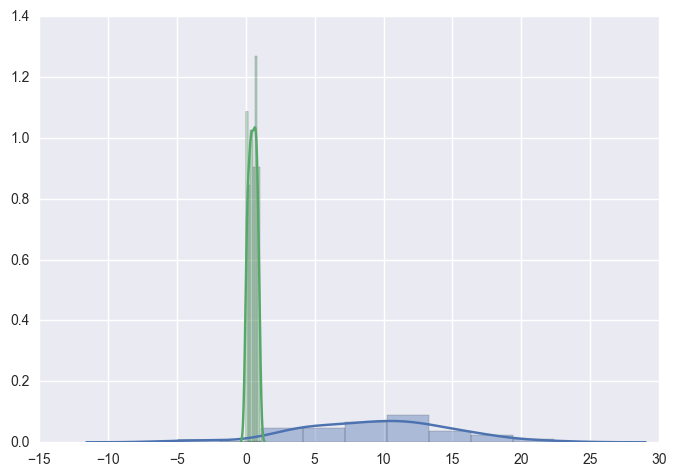

In [2]:
%matplotlib inline
from scipy import stats, integrate

# Plot the two series
sns.set(color_codes=True)
sns.distplot(n_series)
sns.distplot(non_n_series)

## 1. Is the data "normal"?

In [3]:
from scipy import stats

# Test if the X is normal; centered around zero and nicely distributed.
def test_norm(x):
    #Conduct Kolmogorov-Smirnov test
    (kstat, pvalue) = stats.mstats.normaltest(x)
    print "The series is" + (" not " if pvalue <= 0.05 else " ") + "normal"
    return pvalue > 0.05

test_norm(n_series) #Test the "known" normal series
test_norm(non_n_series) #How about non-normal series
pass

The series is normal
The series is not normal


## 2. Is the data "stationary"?

Create two other normal series. One series has the same standard deviation (of 5) but different mean. The other series has the same mean (of 10) but different standard deviation that our prior series.

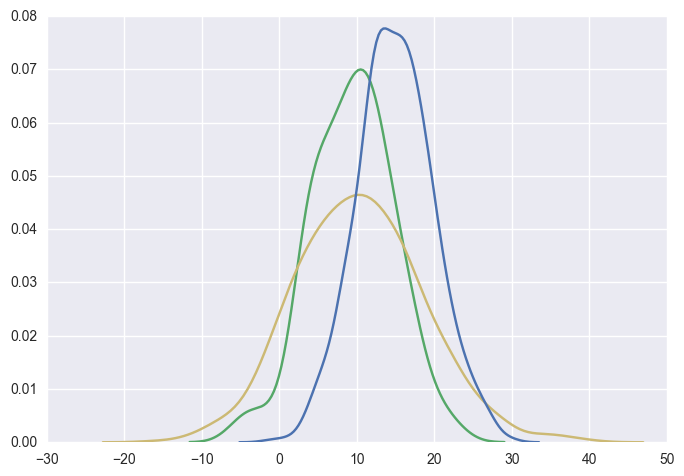

In [4]:
# Make a copy of our known prior series
known_n_series = n_series

# Create a new series with same mean of 10 but wider standard deviation
n_series_with_diff_stddev = np.random.normal(10, 8, 1000)

# Create another new series with same standard deviation but mean higher than previous
n_series_with_diff_mean = np.random.normal(15, 5, 1000)

# Plot the series to visually show the series
# Original series is green
sns.distplot(known_n_series, color="g", hist=False)
# Wider series is yellow
sns.distplot(n_series_with_diff_stddev, color="y", hist=False)
# Shifted series is blue
sns.distplot(n_series_with_diff_mean, color="b", hist=False)

### Has the series shifted its "center"/mean?

In [5]:
# Do two series have same mean?
def test_drift(x,y):
    (tstat, pvalue) = stats.ttest_ind(x - x.mean(), y - x.mean())
    print "The series have" + (" different " if pvalue <= 0.05 else " same ") + "mean"
    return pvalue <= 0.05

#Test drift when series has not moved; can have different variance
test_drift(known_n_series, n_series_with_diff_stddev)

#Test drift when series has moved 5 unit
test_drift(known_n_series, n_series_with_diff_mean) 
pass

The series have same mean
The series have different mean


### Has the series's variance/expanse changed?

In [8]:
# Do two series have same variance?
def test_var_drift(x,y):
    #Use levene test to test variance; also called homoscedasticity
    (tstat, pvalue) = stats.levene(x - x.mean(), y - y.mean())
    print "The series have" + (" different " if pvalue <= 0.05 else " same ") + "standard deviation"
    return pvalue <= 0.05

# Test variance drift when series has not moved
test_var_drift(known_n_series, n_series_with_diff_mean)

# Test variance drift when series has moved
test_var_drift(known_n_series, n_series_with_diff_stddev) 
pass

The series have same standard deviation
The series have different standard deviation


## Significant Difference

Based on a real wine dataset, http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.names, analyze if there is substantive difference in alohol and malic acid levels of three kinds of wine.

In [24]:
# Download the wine dataset
# Initialize the data model that one would expect from the dataset
col_names = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280_OD315', 'Proline']

# Fetch the data
wines = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', names=col_names, index_col=False)

# Change the class of the wine to a categorical type from numeric type
wines['WineClass'] = wines.Class.apply(lambda x: 'Wine ' + str(x))
# Display a preview
display(wines)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280_OD315,Proline,WineClass
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,Wine 1
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,Wine 1
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,Wine 1
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,Wine 1
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,Wine 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,Wine 3
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,Wine 3
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,Wine 3
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,Wine 3


## Measure Feature Differences

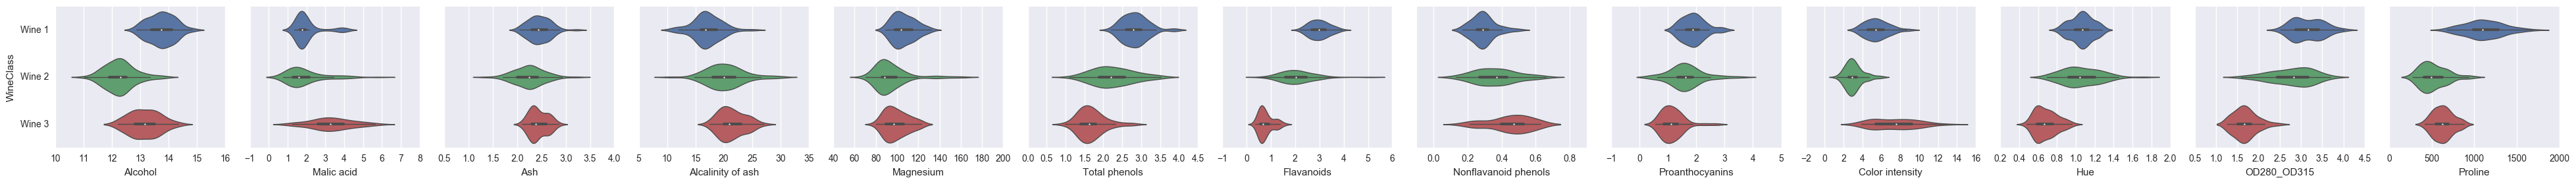

In [64]:
# Find all "continuous features"
all_measures = [x for x in wines.select_dtypes(include=['number']).columns.values if 'Class' not in x]

# What are we plotting means against
class_feature = 'WineClass'

# Plot visually to see if each feature is substantively different between each class
sns.PairGrid(wines, 
             x_vars=all_measures,
             y_vars=class_feature, size=3).\
    map(sns.violinplot, palette="deep", linewidth=1)

## For each feature, how do wines differ (if they differ)

In [65]:
# Are the feature/per-feature measurement "clumps" similar between wines
# We will conduct Tukey test to find pairwise differences. Tukey test is similar to ttest
# But since we have multiple groups (wine 1, 2, and 3 leading to 1-2, 2-3, 1-3 comparisons) 
# it is better to use tukey test (or bonferroni test) since stddev is normalized across the groups
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Along each feature, compare the wines and see if the mean/variance is significantly different
for feature in all_measures:
    compare_result = pairwise_tukeyhsd(wines[feature], wines[class_feature])
    display(HTML('<h4>When comparing feature <u><i>{0}</i></u>, we must conclude the groups are {1}</h4><br/><pre>{2}</pre><hr/>'.\
                 format(feature, 
                        'different' if any(compare_result.reject) else 'same', 
                        compare_result.summary())))

<hr />